In [1]:
import traceback
# you need to run "pip install -U segmentation-models"
import segmentation_models as sm
from tensorflow import keras
import unet_utils as loadData
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve,precision_recall_curve,auc,jaccard_score,f1_score,accuracy_score


2022-04-09 23:44:28.560025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpf/tools/centos7/tcltk/8.6.11/lib:/hpf/tools/centos6/gdal/2.4.0/lib/:/hpf/tools/centos6/netcdf/4.3.2/lib/:/hpf/tools/centos6/libtiff/4.0.9/lib/:/hpf/tools/centos7/sqlite/3.35.3/lib:/hpf/tools/centos7/proj/7.2.0/lib:/hpf/tools/centos6/geos/3.4.2/lib:/hpf/tools/centos6/libpng/1.2.59/lib/:/hpf/tools/centos7/udunits2/2.2.28/lib:/hpf/tools/centos7/hdf5/1.10.5/lib:/hpf/tools/centos7/R/4.0.4_pbalin/lib64:/hpf/tools/centos7/pcre/8.44.utf8/lib:/hpf/tools/centos7/libxml2/2.9.1/lib64:/hpf/tools/centos7/curl/7.74.0/lib:/hpf/tools/centos7/readline/8.1/lib:/hpf/tools/centos6/gcc/7.2.0/lib64/:/hpf/tools/centos6/gcc/7.2.0/lib/:/hpf/tools/centos7/python/3.9.2_pbalin/lib:/hpf/largeprojects/tabori/shared/software/lib:/usr/lib64/
2022-04-09 23:44:28.560054: I 

Segmentation Models: using `keras` framework.


In [2]:
#remember to change the data path in loadData.py

In [3]:
#you don't need to change anything here
#unless 
#you might want to comment the netx line if you enconter environment issue
sm.set_framework('tf.keras')


sm.framework()
#define model
BACKBONE = 'vgg19'
CLASSES = ['NCI', 'GCI','_background_']


preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights=None,classes=3, activation='softmax',input_shape=(None, None, 3),encoder_freeze=True)
model.load_weights('tuning_model_000_newbase.h5')

2022-04-09 23:45:20.170590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpf/tools/centos7/tcltk/8.6.11/lib:/hpf/tools/centos6/gdal/2.4.0/lib/:/hpf/tools/centos6/netcdf/4.3.2/lib/:/hpf/tools/centos6/libtiff/4.0.9/lib/:/hpf/tools/centos7/sqlite/3.35.3/lib:/hpf/tools/centos7/proj/7.2.0/lib:/hpf/tools/centos6/geos/3.4.2/lib:/hpf/tools/centos6/libpng/1.2.59/lib/:/hpf/tools/centos7/udunits2/2.2.28/lib:/hpf/tools/centos7/hdf5/1.10.5/lib:/hpf/tools/centos7/R/4.0.4_pbalin/lib64:/hpf/tools/centos7/pcre/8.44.utf8/lib:/hpf/tools/centos7/libxml2/2.9.1/lib64:/hpf/tools/centos7/curl/7.74.0/lib:/hpf/tools/centos7/readline/8.1/lib:/hpf/tools/centos6/gcc/7.2.0/lib64/:/hpf/tools/centos6/gcc/7.2.0/lib/:/hpf/tools/centos7/python/3.9.2_pbalin/lib:/hpf/largeprojects/tabori/shared/software/lib:/usr/lib64/
2022-04-09 23:45:20.170628: W tensorflow

In [4]:
#load the data, pp means preproceesed
x_train,y_train = loadData.load_data()
x_train_pp = preprocess_input(x_train)
y_train = y_train.astype('float32')
#scale y to (0,1) by dividing it by 2
y_train = y_train/128

x_test,y_test = loadData.load_test()
y_test = y_test.astype('float32')
y_test=y_test/128
x_test_pp = preprocess_input(x_test)

In [5]:
#this is to predict the i-th figure in x_train, 
#change it to whatever you want
i=117

pr_mask = model.predict(np.expand_dims(x_train_pp[i],axis=0))

#remember to threshold after training, you can change the threshold here
#the 'threshold()' function is in loadData.py
pr_mask=loadData.threshold(pr_mask,0.995,0.995)



(-0.5, 255.5, 255.5, -0.5)

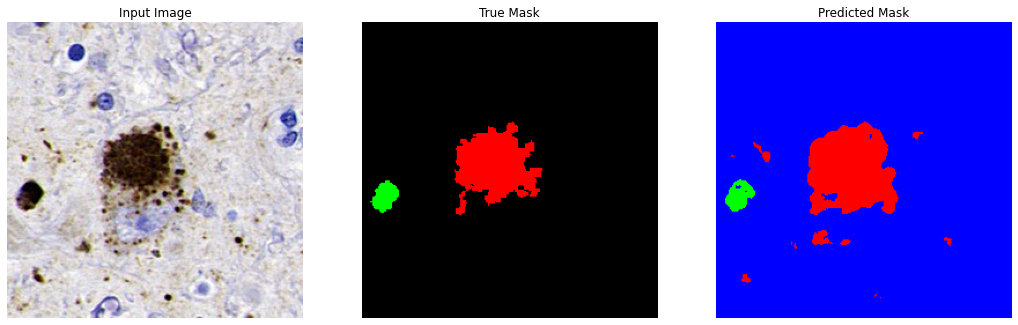

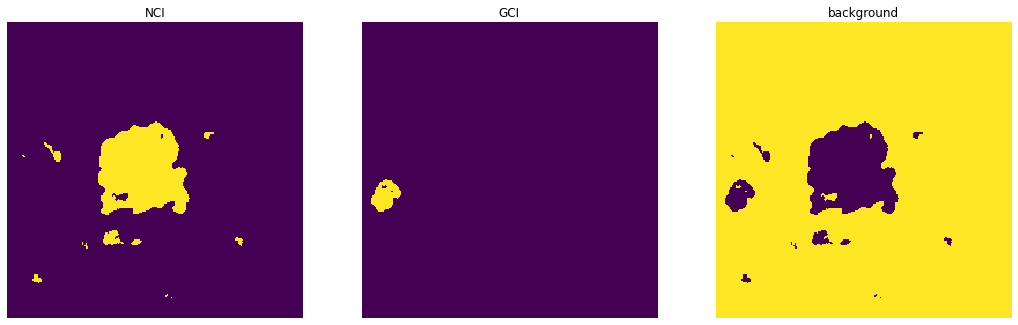

In [6]:
#this is a quick display of 'Input Image', 'True Mask', 'Predicted Mask'
loadData.display_sample([x_train[i], y_train[i],np.squeeze(pr_mask, axis=0)],'tuning_model.png')

#this is how you can plot the individual masks
pred=np.squeeze(pr_mask, axis=0)
fig,ax=plt.subplots(figsize=(18,18))
ax1=plt.subplot(131)
ax1.imshow(pred[...,0], interpolation='nearest')
ax1.set_title('NCI')
plt.axis('off')
ax2=plt.subplot(132)
ax2.imshow(pred[...,1], interpolation='nearest')
ax2.set_title('GCI')
plt.axis('off')
ax3=plt.subplot(133)
ax3.imshow(pred[...,2], interpolation='nearest')
ax3.set_title('background')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

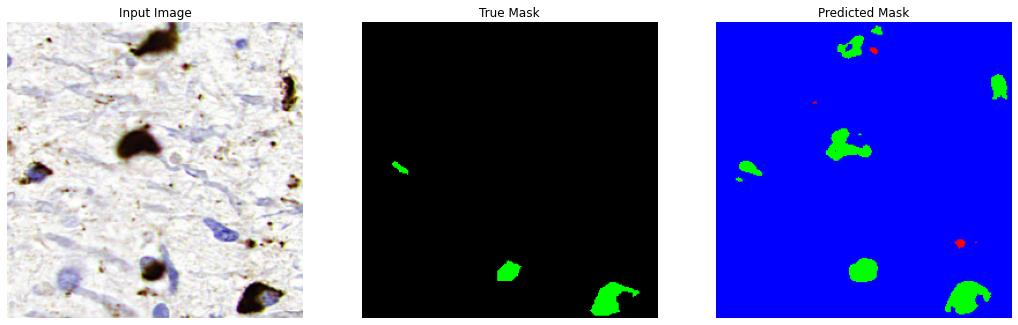

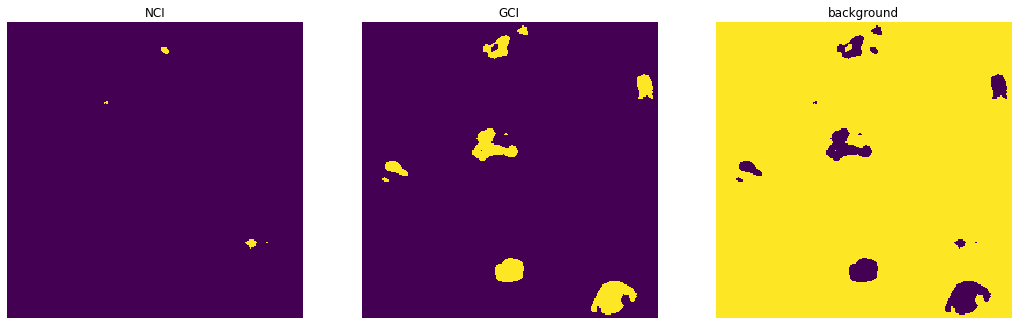

In [7]:
#same thing for the test data

#i=39
i=33
pr_mask = model.predict_on_batch(np.expand_dims(x_test_pp[i],axis=0))
pr_mask=loadData.threshold(pr_mask,0.995,0.995)

loadData.display_sample([x_test[i], y_test[i],np.squeeze(pr_mask, axis=0)],'tuning_model.png')

#plot the masks
pred=np.squeeze(pr_mask, axis=0)
fig,ax=plt.subplots(figsize=(18,18))
ax1=plt.subplot(131)
ax1.imshow(pred[...,0], interpolation='nearest')
ax1.set_title('NCI')
plt.axis('off')
ax2=plt.subplot(132)
ax2.imshow(pred[...,1], interpolation='nearest')
ax2.set_title('GCI')
plt.axis('off')
ax3=plt.subplot(133)
ax3.imshow(pred[...,2], interpolation='nearest')
ax3.set_title('background')
plt.axis('off')

In [8]:
#predict all test data
#it'll take a while to predict all training data
pr_all = model.predict_on_batch(x_test_pp)
pr_all_raw = pr_all.copy()
#
for i in range(len(pr_all)):
    pr_all[i]=loadData.threshold(pr_all[i],0.995,0.995)

In [9]:
#0 is NCI, 1 is GCI, 2 is background
#you can see the values of each pixel in this way:
#0 means the 0-th figure
#... skips all middle arguments so you don't have to specifiy the 256*256 width and height
#1 is the second channel which represents GCI
#pr_all[...,1]

In [10]:
prcurve_nci = precision_recall_curve(y_test[...,0].flatten(),pr_all_raw[...,0].flatten())
auc_pr_nci=auc(prcurve_nci[1],prcurve_nci[0])
prcurve_gci = precision_recall_curve(y_test[...,1].flatten(),pr_all_raw[...,1].flatten())
auc_pr_gci=auc(prcurve_gci[1],prcurve_gci[0])
roccurve_nci = roc_curve(y_test[...,0].flatten(),pr_all_raw[...,0].flatten())
auc_roc_nci=auc(roccurve_nci[0],roccurve_nci[1])
roccurve_gci = roc_curve(y_test[...,1].flatten(),pr_all_raw[...,1].flatten())
auc_roc_gci=auc(roccurve_gci[0],roccurve_gci[1])

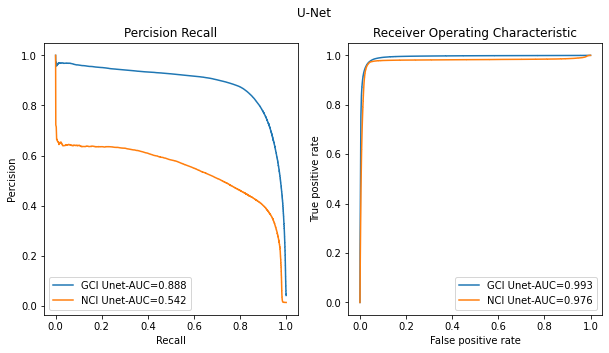

In [11]:
fig_curve,ax_curve = plt.subplots(figsize=(10,5))
ax_pr = plt.subplot(121)
plt.plot(prcurve_nci[1],prcurve_nci[0],label=f'GCI Unet-AUC={auc_pr_nci:.3f}')
plt.plot(prcurve_gci[1],prcurve_gci[0],label=f'NCI Unet-AUC={auc_pr_gci:.3f}')
plt.title('Percision Recall')
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.legend(loc=3)
ax_roc = plt.subplot(122)
plt.plot(roccurve_nci[0],roccurve_nci[1],label=f'GCI Unet-AUC={auc_roc_nci:.3f}')
plt.plot(roccurve_gci[0],roccurve_gci[1],label=f'NCI Unet-AUC={auc_roc_gci:.3f}')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.suptitle('U-Net')
fig_curve.savefig('unet_curve.png',dpi=500)

In [12]:
all_iou = jaccard_score((y_test).flatten(),(pr_all).flatten())
NCI_iou = jaccard_score((y_test[...,0]).flatten(),(pr_all[...,0]).flatten())
GCI_iou = jaccard_score((y_test[...,1]).flatten(),(pr_all[...,1]).flatten())
print(f'general iou score = {all_iou}')
print(f'NCI iou score = {NCI_iou}')
print(f'GCI iou score = {GCI_iou}')

general iou score = 0.04623339340735008
NCI iou score = 0.7276407696139189
GCI iou score = 0.4168732782369146


In [13]:
all_f1 = f1_score((y_test).flatten(),(pr_all).flatten())
NCI_f1 = f1_score((y_test[...,0]).flatten(),(pr_all[...,0]).flatten())
GCI_f1 = f1_score((y_test[...,1]).flatten(),(pr_all[...,1]).flatten())
print(f'general f1 score = {all_f1}')
print(f'NCI f1 score = {NCI_f1}')
print(f'GCI f1 score = {GCI_f1}')

general f1 score = 0.08838064947779609
NCI f1 score = 0.8423519315031294
GCI f1 score = 0.5884411607446652


In [14]:
all_acc = accuracy_score((y_test).flatten(),(pr_all).flatten())
NCI_acc = accuracy_score((y_test[...,0]).flatten(),(pr_all[...,0]).flatten())
GCI_acc = accuracy_score((y_test[...,1]).flatten(),(pr_all[...,1]).flatten())
print(f'general accuracy score = {all_acc}')
print(f'NCI accuracy score = {NCI_acc}')
print(f'GCI accuracy score = {GCI_acc}')

general accuracy score = 0.6793782935952241
NCI accuracy score = 0.9864614234780366
GCI accuracy score = 0.9853740188310731
